Import assets

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Input, Lambda, Dense, Flatten, Activation, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import applications

C:\Users\s0ludjaa\AppData\Local\Programs\Python\Python39\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.0.0)/charset_normalizer (2.0.6) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


Data Visualization

In [2]:
train = list(os.walk('data/Train'))

In [3]:
label_names = train[0][1]
dict_labels = dict(zip(label_names, list(range(len(label_names)))))
print(dict_labels)

{'Altocumulus': 0, 'Altostratus': 1, 'Cirrocumulus': 2, 'Cirrostratus': 3, 'Cirrus': 4, 'Cumulonimbus': 5, 'Cumulus': 6, 'Nimbostratus': 7, 'Stratocumulus': 8, 'Stratus': 9}


In [4]:
def dataset(path): #put path till the highest directory level
    images = []
    labels = []
    for folder in tqdm(os.listdir(path)):
        value_of_label = dict_labels[folder] #dict_labels is the dictionary whose key:value pairs are classes:numbers representing them

        for file in (os.listdir(os.path.join(path, folder))):
            path_of_file = os.path.join(os.path.join(path, folder), file)

            image = cv2.imread(path_of_file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            images.append(image)
            labels.append(value_of_label)

    images = np.array(images, dtype = 'float32')/255.0
    labels = np.array(labels)

    return images, labels

images, labels = dataset('data/Train')
images, labels = shuffle(images, labels)

100%|██████████| 10/10 [00:35<00:00,  3.57s/it]


In [5]:
images.shape

(1910, 224, 224, 3)

<AxesSubplot:>

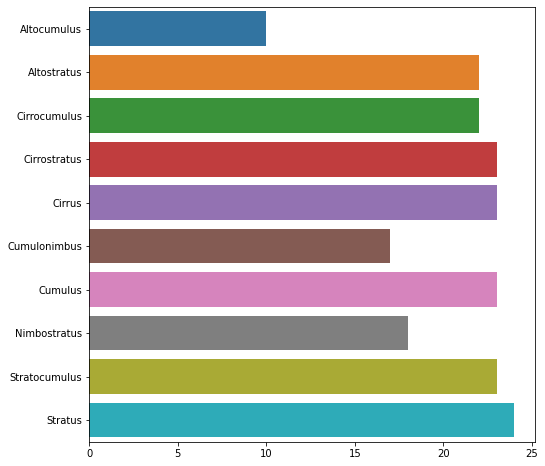

In [6]:
shapes = train[0][1]
no_of_shapes = []
for _ in range(0, 10):
    no_of_shapes.append(len(train[_][0]))
plt.figure(figsize = (8, 8))
sns.barplot(y = shapes, x = no_of_shapes)

Sample images

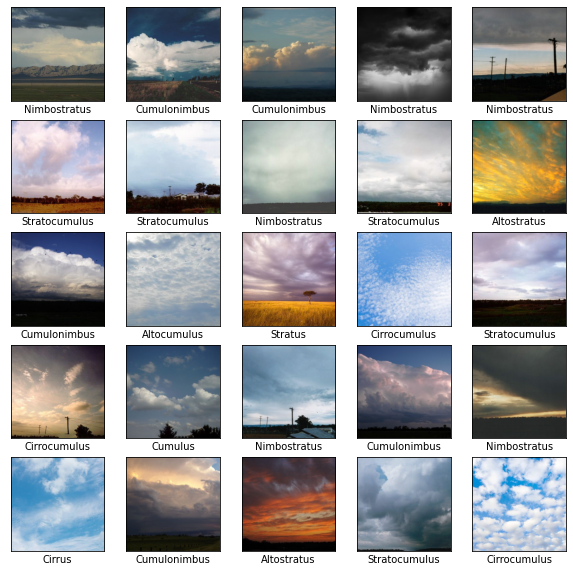

In [7]:
plt.figure(figsize = (10,10))
for _ in range(25):
    plt.subplot(5, 5, _+1)
    plt.yticks([])
    plt.xticks([])
    plt.grid(False)
    data = images[_]
    plt.xlabel(label_names[labels[_]])
    plt.imshow(data)

Load images

In [8]:
image_size = (224, 224)
batch_size = 16
train_datagen = ImageDataGenerator(rescale = 1./255,
                            shear_range = 0.4,
                            zoom_range = 0.4,
                            horizontal_flip = True,
                            vertical_flip = True,
                            validation_split = 0.2)

In [9]:
train_ds = train_datagen.flow_from_directory('data/Train',
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'training',
                                      color_mode="rgb",)

val_ds = train_datagen.flow_from_directory('data/Predict',
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'validation',
                                      color_mode="rgb")

Found 1528 images belonging to 10 classes.
Found 82 images belonging to 10 classes.


In [10]:
train_ds.class_indices

{'Altocumulus': 0,
 'Altostratus': 1,
 'Cirrocumulus': 2,
 'Cirrostratus': 3,
 'Cirrus': 4,
 'Cumulonimbus': 5,
 'Cumulus': 6,
 'Nimbostratus': 7,
 'Stratocumulus': 8,
 'Stratus': 9}

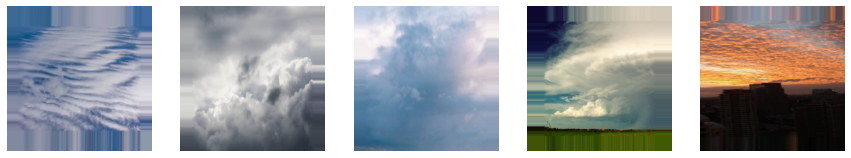

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))

for i in range(5):
    image = next(train_ds)[0][0]
    image = np.squeeze(image)
    ax[i].imshow(image)
    ax[i].axis(False)

Transfer learning

In [12]:
res_base = applications.ResNet152V2(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
res_base.trainable = False

inputs = Input(shape=(224, 224, 3))

x = res_base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation = 'sigmoid')(x)
res_model = Model(inputs, outputs)

In [13]:
res_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss= keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics= [keras.metrics.CategoricalAccuracy()],
)

In [14]:
#epochs = 12
#res_model.fit(train_ds, epochs=epochs, validation_data=val_ds) 

Save model


In [15]:
#res_model.save('res.hdf5')

Predict picture of own cloud

In [16]:
from keras.models import load_model

DictForAltitude = {
    4: 'High',
    2: 'High', 
    3: 'High', 
    0: 'Medium',
    1: 'Medium',
    7: 'Medium', 
    5: 'Low',
    6: 'Low',
    8: 'Low',
    9: 'Low'
    }

DictForEstimate = {
    4: 'The highest and least-substantial clouds. Composed of ice crystals, cirrus clouds lie at altitudes of about 45,000 feet. Wispy and lying at oblique angles, these clouds may herald the approach of a warm front.',
    2: 'Have barely-defined puffy balls and, like cirrostratus, lie at altitudes of 16,500 to 40,000 feet, usually in large clumps. From below, these clouds may look like fish scales. The saying "mackerel sky mackerel sky, not long wet, not long dry" describes them and the changeable weather that follows.', 
    3: 'Wispy clouds lying in sheets may form a ceiling slightly lower than cirrus clouds as a warm front nears and layers of cold air mix with upper warm air. May drape the entire sky in a gray haze and cause a halo around the sun or moon — an indication of a nearing storm.', 
    0: 'These have grayish-white rolls that look like cirrocumulus but are darker and sometimes appear in layers. If the wind is steady between northeast and south, these clouds promise rain soon.',
    1: 'Sheets of cloud between 6,000 and 23,000 feet. Thicker, darker and more claustrophobic than the higher cirrostratus clouds, they promise rain soon.',
    7: "Heavy, rain-laden, low-lying, dark gray blankets that come with warm fronts and wet nor'easters. Their soggy bases may be just above the earth's surface and be indistinguishable from heavy fog.", 
    5: "Dark, tightly-packed balls that may churn and tower as thunderheads at about 6,000 feet. If broader above than below, it's called an anvil head. This shape is due to violent updrafts through a wide range of temperatures. As the updraft hits, cold air is condensed as a cloud. Winds are strong around these threatening clouds.",
    6: 'Puffy white cotton balls at about 6,000 feet promise fair weather. They may, however, darken and be transformed into stratocumulus or cumulonimbus clouds, which can signal bad weather. Seen over land during the day indicates thermals and promises good sea breezes.',
    8: 'Large, dark, puffy balls occurring in compressed layers and foretell bad weather.',
    9: 'These clouds combine in a dense gray overcast that promises light to heavy rain.'
    }
    

def predictor(img):
    model = load_model('res.hdf5')
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = np.array(image, dtype = 'float32')/255.0
    plt.imshow(image)
    image = image.reshape(1, 224,224,3)
    
    label_names = train_ds.class_indices
    dict_class = dict(zip(list(range(len(label_names))), label_names))
    clas = model.predict(image).argmax()
    name = dict_class[clas]
    altitude = DictForAltitude[clas]
    estimate = DictForEstimate[clas]
    print('The given image is of \nClass-number: {0} \nShape: {1}\nAltitude: {2}\nDescription: {3}'.format(clas, name, altitude, estimate))

get latest file in downloads

In [32]:
import glob
import os.path
from pathlib import Path

def getLastestPicture():
    folder_path = str(Path.home() / "Downloads")
    #folder_path = r'Downloads'
    file_type = r'\*jpg'
    files = glob.glob(folder_path + file_type)
    max_file = max(files, key=os.path.getctime)
    return max_file

Predict lastets downloaded picture

C:\Users\s0ludjaa\Downloads\download.jpg
1/1 [==============================] - 6s 6s/step
The given image is of 
Class-number: 0 
Shape: Altocumulus
Altitude: Medium
Description: These have grayish-white rolls that look like cirrocumulus but are darker and sometimes appear in layers. If the wind is steady between northeast and south, these clouds promise rain soon.


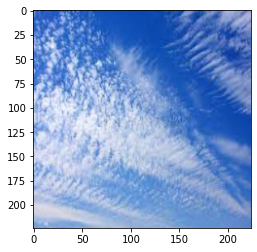

In [35]:
print(getLastestPicture())
latestPicture = getLastestPicture()
predictor(f'{latestPicture}')